# **Introduction**
# **FACE-MASK-DETECTION** 

Face mask detection has a range of applications from capturing the movement of the face to facial recognition which at first requires the face to be detected with very good precision. Face detection is more relevant today as it is not only used on images, but also in video applications like real-time surveillance and face detection in videos.

High precision image classification is now possible with advances in convolutional networks. Pixel level information is often needed after face detection, which most face detection methods do not provide.

Obtaining pixel-level detail has been a difficult part of semantic segmentation. Semantic segmentation is the process of assigning a label to each pixel in the image.


# **Approach**

* Extract face data for training.
* Train the classifier to classify faces in mask or labels without a mask.
* Detect faces while testing data using SSD face detector.
* Using the trained classifier, classify the detected faces.

In the third step of the above process, you have to think about what is the SSD face detector? Well, the **SSD is a Single Shot Multibox Detector**. This is a technique used to detect objects in images using a single deep neural network.

It is used for the detection of objects in an image. Using a basic architecture of the VGG-16 architecture, the SSD can outperform other object detectors such as YOLO and Faster R-CNN in terms of speed and accuracy.

![](https://www.researchgate.net/profile/Adam_Nowosielski/publication/332948824/figure/fig5/AS:767146284036100@1559913335810/The-model-of-Single-Shot-MultiBox-Detector-SSD-25.ppm)

# **Load Data**

Now, let’s get started with the task of Face Mask Detection with Machine Learning by using the Python programming language. I will start this task by importing the necessary Python libraries that we need for this task

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


In [2]:
directory = "Medical mask/annotations"
image_directory = "Medical mask/images"
df = pd.read_csv("train.csv")
df_test = pd.read_csv("submission.csv")

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('architecture.txt',
                                 'weights.caffemodel')

## ** USE OF JSON ** ##
1. The getJSON function retrieves the json file containing the bounding box data in the training dataset.


2. The adjust_gamma function is a non-linear operation used to encode and decode luminance or tristimulus values in video or still image systems. Simply put, it is used to instil a little bit of light into the image. If gamma <1, the image will shift to the darker end of the spectrum and when gamma> 1, there will be more light in the image.
* Also known as Power Law Transform. This function transforms the input image pixelwise according to the equation O = I**gamma after scaling each pixel to the range 0 to 1.
* Enhancing an image provides better contrast and a more detailed image as compare to non enhanced image. Image enhancement has very applications. It is used to enhance medical images, images captured in remote sensing, images from satellite e.t.c


In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# **Data Processing**

The next step is now to explore the JSON data provided for the training.
The Annotations field contains the data of all the faces present in a particular image.
There are different class names, but the real class names are face_with_mask and face_no_mask.

In [5]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '1801.jpg',
 'NumOfAnno': 1,
 'Annotations': [{'isProtected': False,
   'ID': 924868908868875136,
   'BoundingBox': [451, 186, 895, 697],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [6]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


Using the mask and the non_mask labels, the bounding box data of the json files is extracted. The faces of a particular image are extracted and stored in the data list with its tag for the learning process.

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

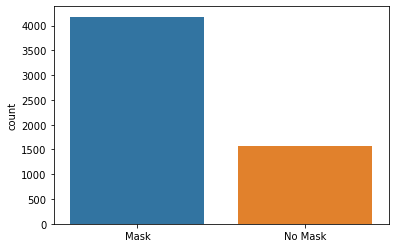

In [7]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)

p = []
for face in data:
    if(face[1] == 0):
        p.append("Mask")
    else:
        p.append("No Mask")
sns.countplot(p)

The visualization above tells us that the number of mask images> Number of images without a mask, so this is an unbalanced dataset. But since we’re using a pre-trained SSD model, which is trained to detect unmasked faces, this imbalance wouldn’t matter much.

let’s reshape the data before training a neural network

In [8]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)

X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

# **Training Model**

Now the next step is to train a Neural Network for the task of Face Mask Detection with Machine Learning

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)

datagen.fit(xtrain)

history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    epochs=20,
                    verbose=1,
                    validation_data=(xval, yval))

C:\Users\Lenovo\AppData\Local\Temp/ipykernel_12484/3563897778.py:32: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),


Epoch 1/20
144/144 [==============================] - 376s 3s/step - loss: 0.3533 - accuracy: 0.8432 - val_loss: 0.2224 - val_accuracy: 0.9087
Epoch 2/20
144/144 [==============================] - 389s 3s/step - loss: 0.2907 - accuracy: 0.8865 - val_loss: 0.2284 - val_accuracy: 0.9096
Epoch 3/20
144/144 [==============================] - 386s 3s/step - loss: 0.2731 - accuracy: 0.8830 - val_loss: 0.2301 - val_accuracy: 0.9000
Epoch 4/20
144/144 [==============================] - 363s 3s/step - loss: 0.2560 - accuracy: 0.9004 - val_loss: 0.2047 - val_accuracy: 0.9226
Epoch 5/20
144/144 [==============================] - 362s 3s/step - loss: 0.2540 - accuracy: 0.8965 - val_loss: 0.1969 - val_accuracy: 0.9287
Epoch 6/20
144/144 [==============================] - 422s 3s/step - loss: 0.2398 - accuracy: 0.9109 - val_loss: 0.1747 - val_accuracy: 0.9304
Epoch 7/20
144/144 [==============================] - 479s 3s/step - loss: 0.2393 - accuracy: 0.9080 - val_loss: 0.2364 - val_accuracy: 0.9035

**Training and Validation Visualizations**

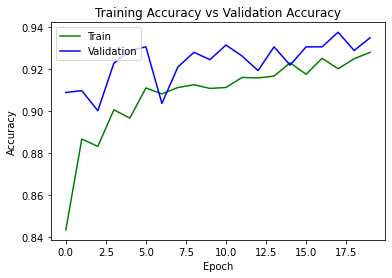

In [10]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

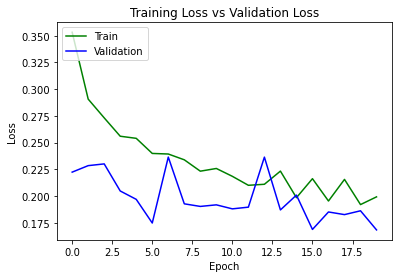

In [11]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## ** Saving The model for deployment ** ##


In [12]:
model.save("Mask_Model.h5")

# **Testing The Model**

1/1 [==============================] - 0s 38ms/step


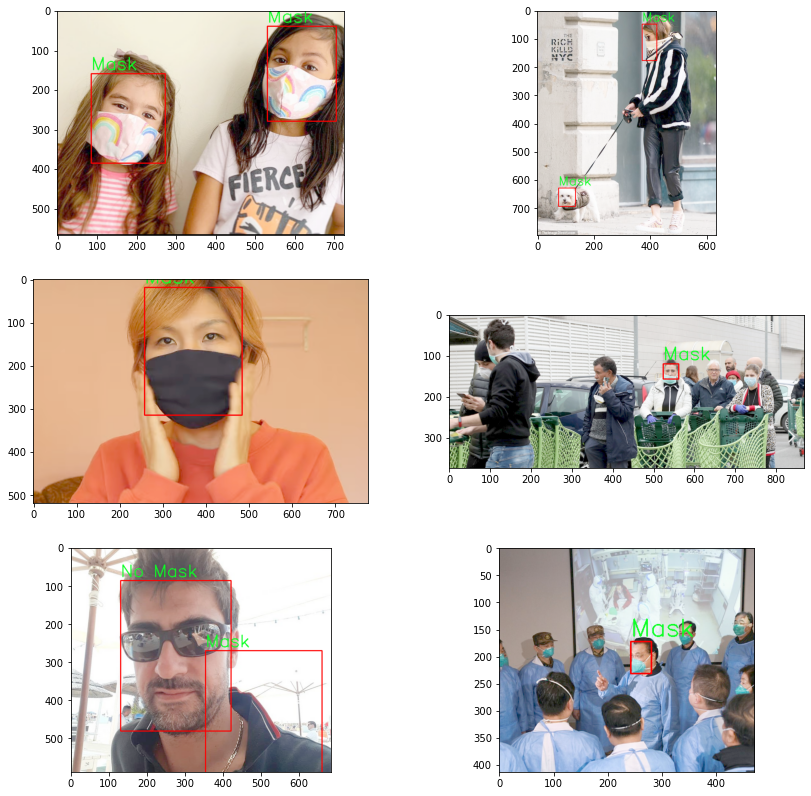

In [13]:
test_images = ['2776.png','5342.jpg', '4591.png','3939.png','2345.png','3811.png']

gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

By analyzing the output above, we can observe that the whole system works well for faces that have spatial dominance. But fails in the case of images where the faces are small and take up less space in the overall image.

For best results, different image preprocessing techniques can be used, or the confidence threshold can be kept lower, or one can try different blob sizes.

Hope you liked this article on face mask detection with machine learning using the Python programming language. 
please feel free to reach me at @kadaliaswinkumar143@gmail.com